# Imports (standard + project specific)

In [116]:
%matplotlib inline
import numpy as np, scipy as sp, pandas as pd, xlwings as xw, seaborn as sns, matplotlib.pyplot as plt
import pathlib, random, attr, eputils, requests, re, loman, yaml, croniter
from datetime import datetime
from collections import OrderedDict
from bs4 import BeautifulSoup
sns.set_style('whitegrid')

import matplotlib as mpl
import shapefile
import shapely, shapely.geometry

In [117]:
from sklearn.model_selection import (
    train_test_split, cross_val_score, 
    KFold, GroupKFold, StratifiedKFold, LeaveOneGroupOut, LeaveOneOut, GroupShuffleSplit,
    GridSearchCV, cross_validate)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import GPy

# Load Data

In [3]:
df_urbanization = pd.read_csv(r"C:\Users\Ed Parcell\Dropbox\Data\Voting 2016 vs Urbanization\538\urbanization-census-tract.csv")

with shapefile.Reader(r"C:\Users\Ed Parcell\Dropbox\Data\Voting 2016 vs Urbanization\Dataverse voting\co_2016\co_2016.dbf") as sf1:
    shapes = sf1.shapes()
    records = sf1.shapeRecords()

Will be better to have records in a dataframe:

In [4]:
df_records = []
for record in records:
    df_records.append(record.record.as_dict())
df_records = pd.DataFrame(df_records)

df_records['CliPct'] = df_records.G16PREDCLI / (df_records.G16PREDCLI + df_records.G16PRERTRU)
df_records['CliPct'].fillna(value=0.5, inplace=True)

# Plot data

We set up a nice red-purple-blue color map, and then plot each shape for Colorado. This confirms that we have the data and are able to intrepret it correctly

In [5]:
def map_str_to_rgb(l):
    return [(v, sns.xkcd_rgb[n]) for v, n in l]

cms_RPB = [(0.0, 'red'), (0.5, 'purple'), (1.0, 'blue')]
cm_RPB = mpl.colors.LinearSegmentedColormap.from_list('RPB', map_str_to_rgb(cms_RPB))

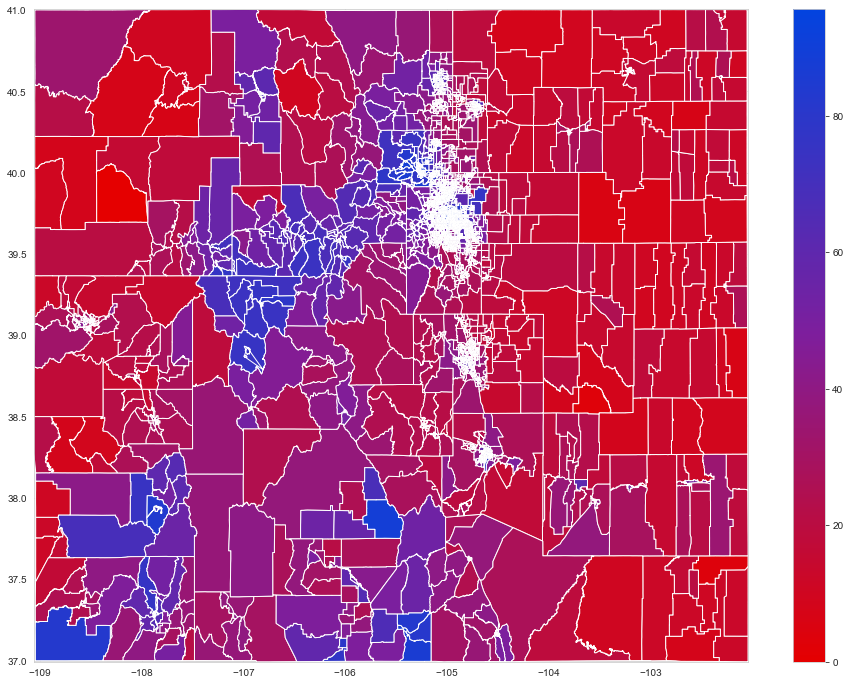

In [6]:
patches = []

for i, shape in enumerate(shapes):
    ds_record = df_records.loc[i]
    cli_pct = ds_record.CliPct
    poly = mpl.patches.Polygon(np.array(shape.points))
    patches.append(poly)
p = mpl.collections.PatchCollection(patches)
p.set_array(100. * df_records.CliPct.values)
p.set_cmap(cm_RPB)

x_min, y_min, x_max, y_max = sf1.bbox

fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.add_collection(p)
fig.colorbar(p, ax=ax)

# Need a single point for each precinct

In [7]:
centroid_xs = []
centroid_ys = []
for shape in shapes:
    poly = shapely.geometry.Polygon(shape.points)
    centroid_xs.append(poly.centroid.x)
    centroid_ys.append(poly.centroid.y)

In [8]:
df_records['Centroid_X'] = centroid_xs
df_records['Centroid_Y'] = centroid_ys

<AxesSubplot:xlabel='Centroid_X', ylabel='Centroid_Y'>

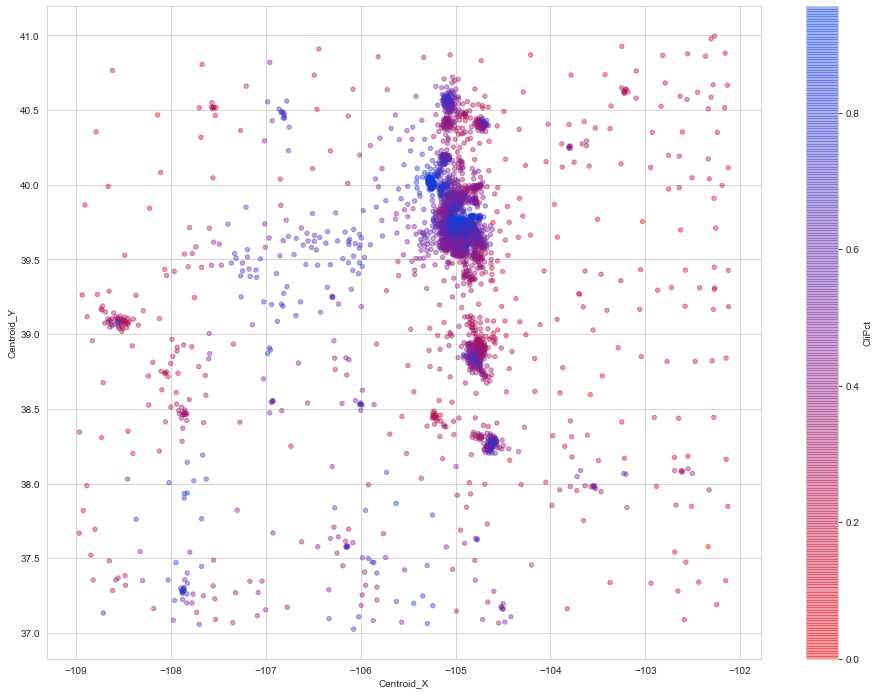

In [9]:
fig, ax = plt.subplots(figsize=(16, 12))
df_records.plot(x='Centroid_X', y='Centroid_Y', c='CliPct', cmap=cm_RPB, kind='scatter', alpha=0.4, ax=ax)

# Now need to be able to look up urbanization for any place in US

In [10]:
cms_urb = [(0.0, 'green'), (0.4, 'green'), (0.6, 'yellow'), (0.8, 'orange'), (0.95, 'red'), (1.0, 'red')]
cm_urb = mpl.colors.LinearSegmentedColormap.from_list('RPB', map_str_to_rgb(cms_urb))

(36.99244900090623, 41.00344400093378)

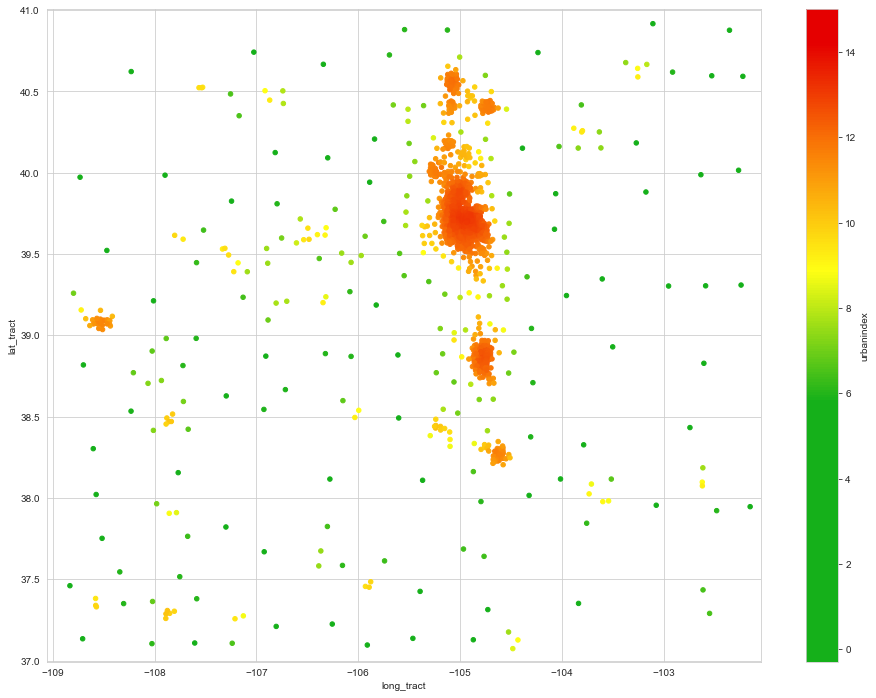

In [11]:
fig, ax = plt.subplots(figsize=(16, 12))
df_urbanization.plot(kind='scatter', x='long_tract', y='lat_tract', c='urbanindex', cmap=cm_urb, ax=ax)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

Let's build a dumb ML regression to get the urbanization value for any point

In [12]:
X = df_urbanization[['long_tract', 'lat_tract']].values
y = df_urbanization.urbanindex.values

In [13]:
regr = KNeighborsRegressor(n_neighbors=3, algorithm='ball_tree').fit(X, y)

In [14]:
xs, ys = np.meshgrid(np.linspace(x_min, x_max, 250), np.linspace(y_min, y_max, 250))
X_all = np.stack([xs.flatten(), ys.flatten()]).T
y_all = regr.predict(X_all)
df_urbanization_pred = pd.DataFrame({'long_tract': X_all[:, 0], 'lat_tract': X_all[:, 1], 'urbanindex': y_all})

(36.99244900090623, 41.00344400093378)

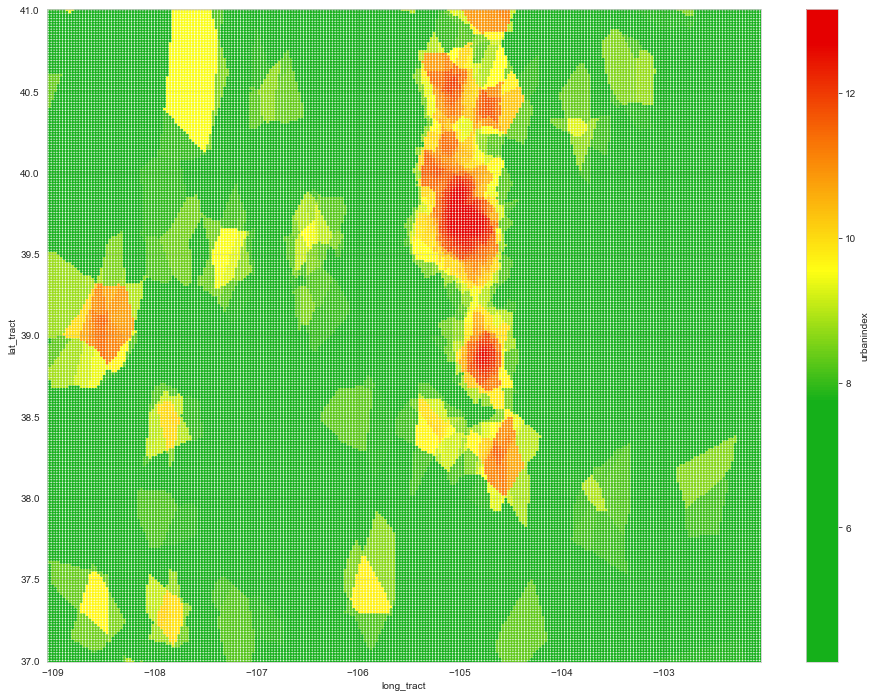

In [15]:
fig, ax = plt.subplots(figsize=(16, 12))
df_urbanization_pred.plot(kind='scatter', x='long_tract', y='lat_tract', c='urbanindex', cmap=cm_urb, ax=ax, s=3)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

Finally, let's use it to add urbanization to our records

In [16]:
X_records = df_records[['Centroid_X', 'Centroid_Y']].values
y_records = regr.predict(X_records)
df_records['UrbanIndex'] = y_records

# Plot urbanization against Clinton voting

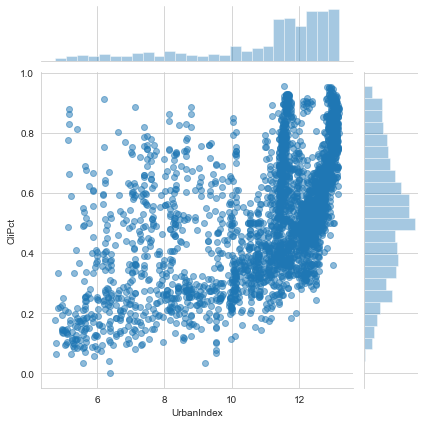

In [17]:
sns.jointplot(x='UrbanIndex', y='CliPct', data=df_records, alpha=0.5)

# Same US wide, please

In [33]:
df_urbanization = pd.read_csv(r"C:\Users\Ed Parcell\Dropbox\Data\Voting 2016 vs Urbanization\538\urbanization-census-tract.csv")

pth_dataverse = pathlib.Path(r'C:\Users\Ed Parcell\Dropbox\Data\Voting 2016 vs Urbanization\Dataverse voting')
df_records = []
centroid_xs = []
centroid_ys = []
for pth_shapefile in pth_dataverse.glob('**\??_2016.dbf'):
    with shapefile.Reader(str(pth_shapefile)) as sf:
        shapes = sf.shapes()
        records = sf.shapeRecords()
    for record in records:
        df_records.append(record.record.as_dict())
    for shape in shapes:
        poly = shapely.geometry.Polygon(shape.points)
        centroid_xs.append(poly.centroid.x)
        centroid_ys.append(poly.centroid.y)        

df_records = pd.DataFrame(df_records)
df_records['Centroid_X'] = centroid_xs
df_records['Centroid_Y'] = centroid_ys
df_records['CliPct'] = df_records.G16PREDCLI / (df_records.G16PREDCLI + df_records.G16PRERTRU)
#df_records['CliPct'].dropna(inplace=True)

X_records = df_records[['Centroid_X', 'Centroid_Y']].values
y_records = regr.predict(X_records)
df_records['UrbanIndex'] = y_records

In [ ]:
# fig, ax = plt.subplots(figsize=(16, 12))
# df_records.plot(x='Centroid_X', y='Centroid_Y', c='CliPct', cmap=cm_RPB, kind='scatter', alpha=0.4, ax=ax)

In [67]:
#df_records.to_parquet(r'C:\Users\Ed Parcell\Dropbox\Data\Voting 2016 vs Urbanization\records.parquet')

In [206]:
sel = (~np.isnan(df_records.CliPct) &
       ~pd.isnull(df_records.NAME) &
       (df_records.Centroid_Y > 20.) & (df_records.Centroid_Y < 70.) &
       (df_records.Centroid_X > -160.) & (df_records.Centroid_X < -60.)
)
df = df_records.loc[sel].copy()

bins = [0, 25000, 100000, 250000, 10000000]
bin_labels = ['Rural', 'Exurban/Small town', 'Suburban/Small City', 'Urban Core/Large City']

df['Cli'] = df.CliPct > 0.5
df['UrbanIndexBin'] = pd.cut(np.exp(df.UrbanIndex), bins=bins, labels=bin_labels)

<AxesSubplot:xlabel='UrbanIndex', ylabel='CliPct'>

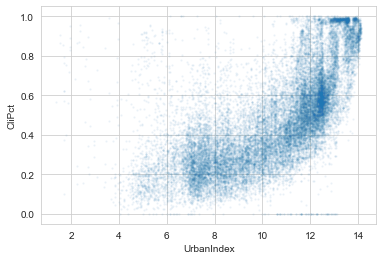

In [207]:
df.loc[sel].plot(kind='scatter', x='UrbanIndex', y='CliPct', s=2, alpha=0.05)

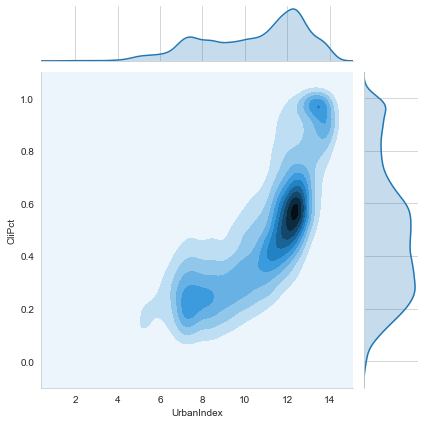

In [208]:
sns.jointplot(data=df, x='UrbanIndex', y='CliPct', kind='kdeplot')

In [209]:
df_foo = df.sample(1000)
X = df_foo[['UrbanIndex']].values
y = df_foo[['CliPct']].values

In [210]:
kernel = GPy.kern.RBF(input_dim=1)
m  = GPy.models.GPRegression(X, y, kernel)

In [211]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -439.6352628900422
Optimization restart 2/10, f = -439.6352628884811
Optimization restart 3/10, f = -439.63526289380246
Optimization restart 4/10, f = -439.63526286402
Optimization restart 5/10, f = -439.6352628669022
Optimization restart 6/10, f = -439.6352628727706
Optimization restart 7/10, f = -439.6352628960161
Optimization restart 8/10, f = -439.6352628945227
Optimization restart 9/10, f = -439.6352628940481
Optimization restart 10/10, f = -439.6352628931737


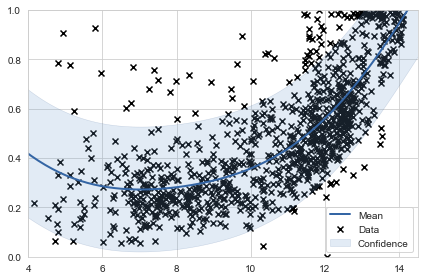

In [212]:
fig = m.plot(xlim=[4., 14.5], ylim=[0., 1.], lower=5, upper=95)

In [225]:
bin_labels

['Rural', 'Exurban/Small town', 'Suburban/Small City', 'Urban Core/Large City']

In [227]:
bins

[0, 25000, 100000, 250000, 10000000]

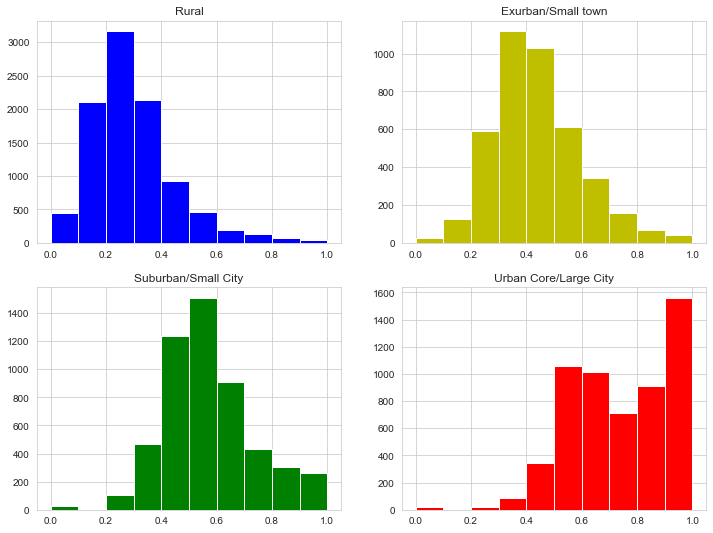

In [246]:
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
for label, lower, upper, ax, c in zip(bin_labels, bins, bins[1:], axs.flatten(), 'bygr'):
    ax.hist(df[(np.exp(df.UrbanIndex) > lower) & (np.exp(df.UrbanIndex) < upper)].CliPct, label=label, color=c)
    ax.set_title(label)

(0.0, 1.0)

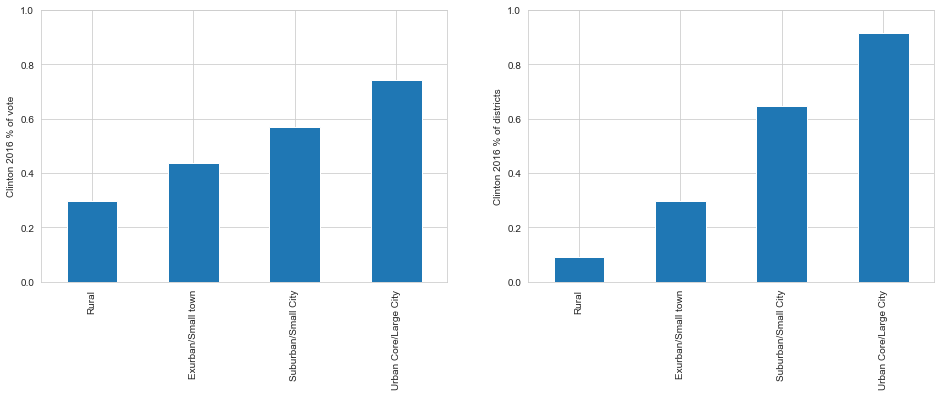

In [224]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

df.groupby('UrbanIndexBin').CliPct.mean().plot(kind='bar', ax=axs[0])
axs[0].set_xlabel("")
axs[0].set_ylabel("Clinton 2016 % of vote")
axs[0].set_ylim(0, 1)

df.groupby('UrbanIndexBin').Cli.mean().plot(kind='bar', ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("Clinton 2016 % of districts")
axs[1].set_ylim(0, 1)

In [248]:
df.groupby('UrbanIndexBin').Cli.mean()

UrbanIndexBin
Rural                    0.092166
Exurban/Small town       0.295792
Suburban/Small City      0.645707
Urban Core/Large City    0.915953
Name: Cli, dtype: float64